# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [47]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [48]:
# Install requirements
!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


## Imports

In [49]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [51]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0), (0.5))])

# Create training set and define training dataloader
raw_data = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transform)
training_data, val_data = torch.utils.data.random_split(raw_data, [int(len(raw_data) * 0.8), int(len(raw_data) * 0.2)])
train_loader = torch.utils.data.DataLoader(training_data, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_data)

# Create test set and define test dataloader
test_data = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I normalized the grayscale channel to have a mean 0.0 and standard deviation of 0.5 in order that all images have similar intensity. There is no need to scale the size of the images since MNIST has all the images in identical size.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [52]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        print(image.shape)
        plt.imshow(image.T.squeeze().T)
        plt.show()

5
(1, 28, 28)


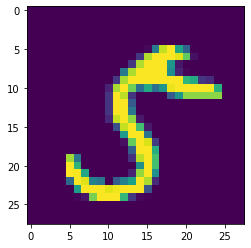

2
(1, 28, 28)


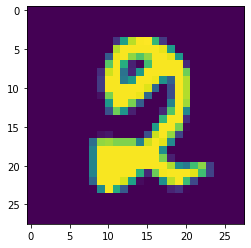

7
(1, 28, 28)


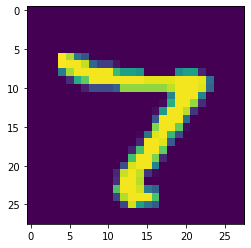

7
(1, 28, 28)


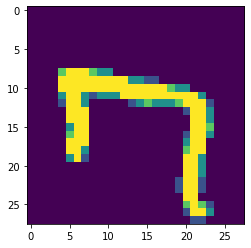

0
(1, 28, 28)


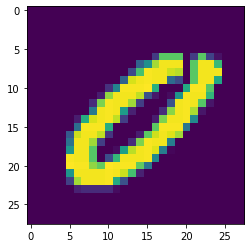

In [53]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [54]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.softmax = F.softmax
        self.fc1 = nn.Linear(28 * 28, 300)
        self.fc2 = nn.Linear(300, 160)
        self.fc3 = nn.Linear(160, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

# Instantiate the model
net = Net()
net.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=160, bias=True)
  (fc3): Linear(in_features=160, out_features=10, bias=True)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [55]:
# Choose an optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

# Choose a loss function
criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [56]:
num_epochs = 10

# Establish a list for our history
train_loss_history = list()
val_loss_history = list()

for epoch in range(num_epochs):
    net.train()
    
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
    
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader.dataset)*100:.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))

    val_loss = 0.0
    val_correct = 0
    net.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
        
    N = len(val_loader.dataset)
    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/N*100:.2f}% validation loss: {val_loss/N:.5f}')
    val_loss_history.append(val_loss/N)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Epoch 1 training accuracy: 88.68% training loss: 1.58581
Epoch 1 validation accuracy: 93.57% validation loss: 1.53411
Epoch 2 training accuracy: 93.96% training loss: 1.52963
Epoch 2 validation accuracy: 94.88% validation loss: 1.52098
Epoch 3 training accuracy: 95.06% training loss: 1.51857
Epoch 3 validation accuracy: 95.20% validation loss: 1.51676
Epoch 4 training accuracy: 95.72% training loss: 1.51251
Epoch 4 validation accuracy: 95.81% validation loss: 1.51090
Epoch 5 training accuracy: 96.06% training loss: 1.50896
Epoch 5 validation accuracy: 96.01% validation loss: 1.50763
Epoch 6 training accuracy: 96.25% training loss: 1.50722
Epoch 6 validation accuracy: 96.28% validation loss: 1.50651
Epoch 7 training accuracy: 96.45% training loss: 1.50510
Epoch 7 validation accuracy: 95.67% validation loss: 1.51365
Epoch 8 training accuracy: 96.66% training loss: 1.50336
Epoch 8 validation accuracy: 96.48% validation loss: 1.50450
Epoch 9 training accuracy: 96.73% training loss: 1.50277

Plot the training loss (and validation loss/accuracy, if recorded).

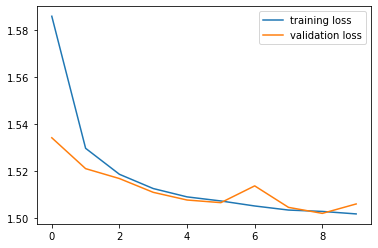

In [57]:
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.legend(['training loss', 'validation loss'])

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [58]:
net.eval()
test_correct = 0

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = net(inputs)

    _, preds = torch.max(outputs.data, 1)
    test_correct += (preds == labels).sum().item()

print(f'Test accuracy: {test_correct/len(test_loader.dataset)*100:.2f}%')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Test accuracy: 96.22%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [59]:
## YOUR CODE HERE ##

## Saving your model
Using `torch.save`, save your model for future loading.

In [60]:
## YOUR CODE HERE ##